In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import seaborn as sns

In [16]:
directory_path = './data/extracted'
schools = [os.path.join(directory_path, folder) for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

In [ ]:
def extract_graph(graph_path, directed=True):
    edges_df = pd.read_csv(f'{graph_path}/edges.csv', header=0, names=['source', 'target', 'weight'])
    nodes_df = pd.read_csv(f'{graph_path}/nodes.csv', header=0, index_col='# index')
    if directed:
        G = nx.from_pandas_edgelist(edges_df, 'source', 'target', create_using=nx.DiGraph())
    else:
        G = nx.from_pandas_edgelist(edges_df, 'source', 'target')
    for _, row in nodes_df.iterrows():
        node_id = row.name  # This is the '# index' value
        if node_id in G.nodes:            
            G.nodes[node_id]['name'] = row[' name']
            G.nodes[node_id]['prosocial'] = row[' prosocial']
            G.nodes[node_id]['Sexo'] = row[' Sexo']
            G.nodes[node_id]['Curso'] = row[' Curso']
            G.nodes[node_id]['Grupo'] = row[' Grupo']
            G.nodes[node_id]['crttotal'] = row[' crttotal']
    return G

def print_graph_metrics(G, graph_name):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    print(f"School: {graph_name}")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Average degree: {avg_degree:.2f}")

In [ ]:
graphs = {}
for s in schools:
    g = extract_graph(s)
    graphs[s] = g
    print_graph_metrics(g, s.split('/')[-1].split('.')[0])

School: 1
Number of nodes: 409
Number of edges: 8557
Average degree: 41.84
School: 11_4
Number of nodes: 1914
Number of edges: 1793
Average degree: 1.87
School: 6
Number of nodes: 534
Number of edges: 12812
Average degree: 47.99
School: 11_8
Number of nodes: 3644
Number of edges: 3267
Average degree: 1.79
School: 11_6
Number of nodes: 2548
Number of edges: 2403
Average degree: 1.89
School: 2
Number of nodes: 238
Number of edges: 3755
Average degree: 31.55
School: 11_10
Number of nodes: 8071
Number of edges: 7613
Average degree: 1.89
School: 11_2
Number of nodes: 12662
Number of edges: 11960
Average degree: 1.89
School: 11_5
Number of nodes: 4498
Number of edges: 4498
Average degree: 2.00
School: 11_3
Number of nodes: 4371
Number of edges: 4176
Average degree: 1.91
School: 11_7
Number of nodes: 1531
Number of edges: 1426
Average degree: 1.86
School: 11_9
Number of nodes: 6894
Number of edges: 6379
Average degree: 1.85
School: 11_1
Number of nodes: 5826
Number of edges: 5535
Average degr

## Community

Detecting communities using the Louvain method...
School 1, Number of detected communities: 5
School 11_4, Number of detected communities: 121
School 6, Number of detected communities: 4
School 11_8, Number of detected communities: 377
School 11_6, Number of detected communities: 145
School 2, Number of detected communities: 6
School 11_10, Number of detected communities: 458
School 11_2, Number of detected communities: 702
School 11_5, Number of detected communities: 65
School 11_3, Number of detected communities: 195
School 11_7, Number of detected communities: 105
School 11_9, Number of detected communities: 515
School 11_1, Number of detected communities: 291


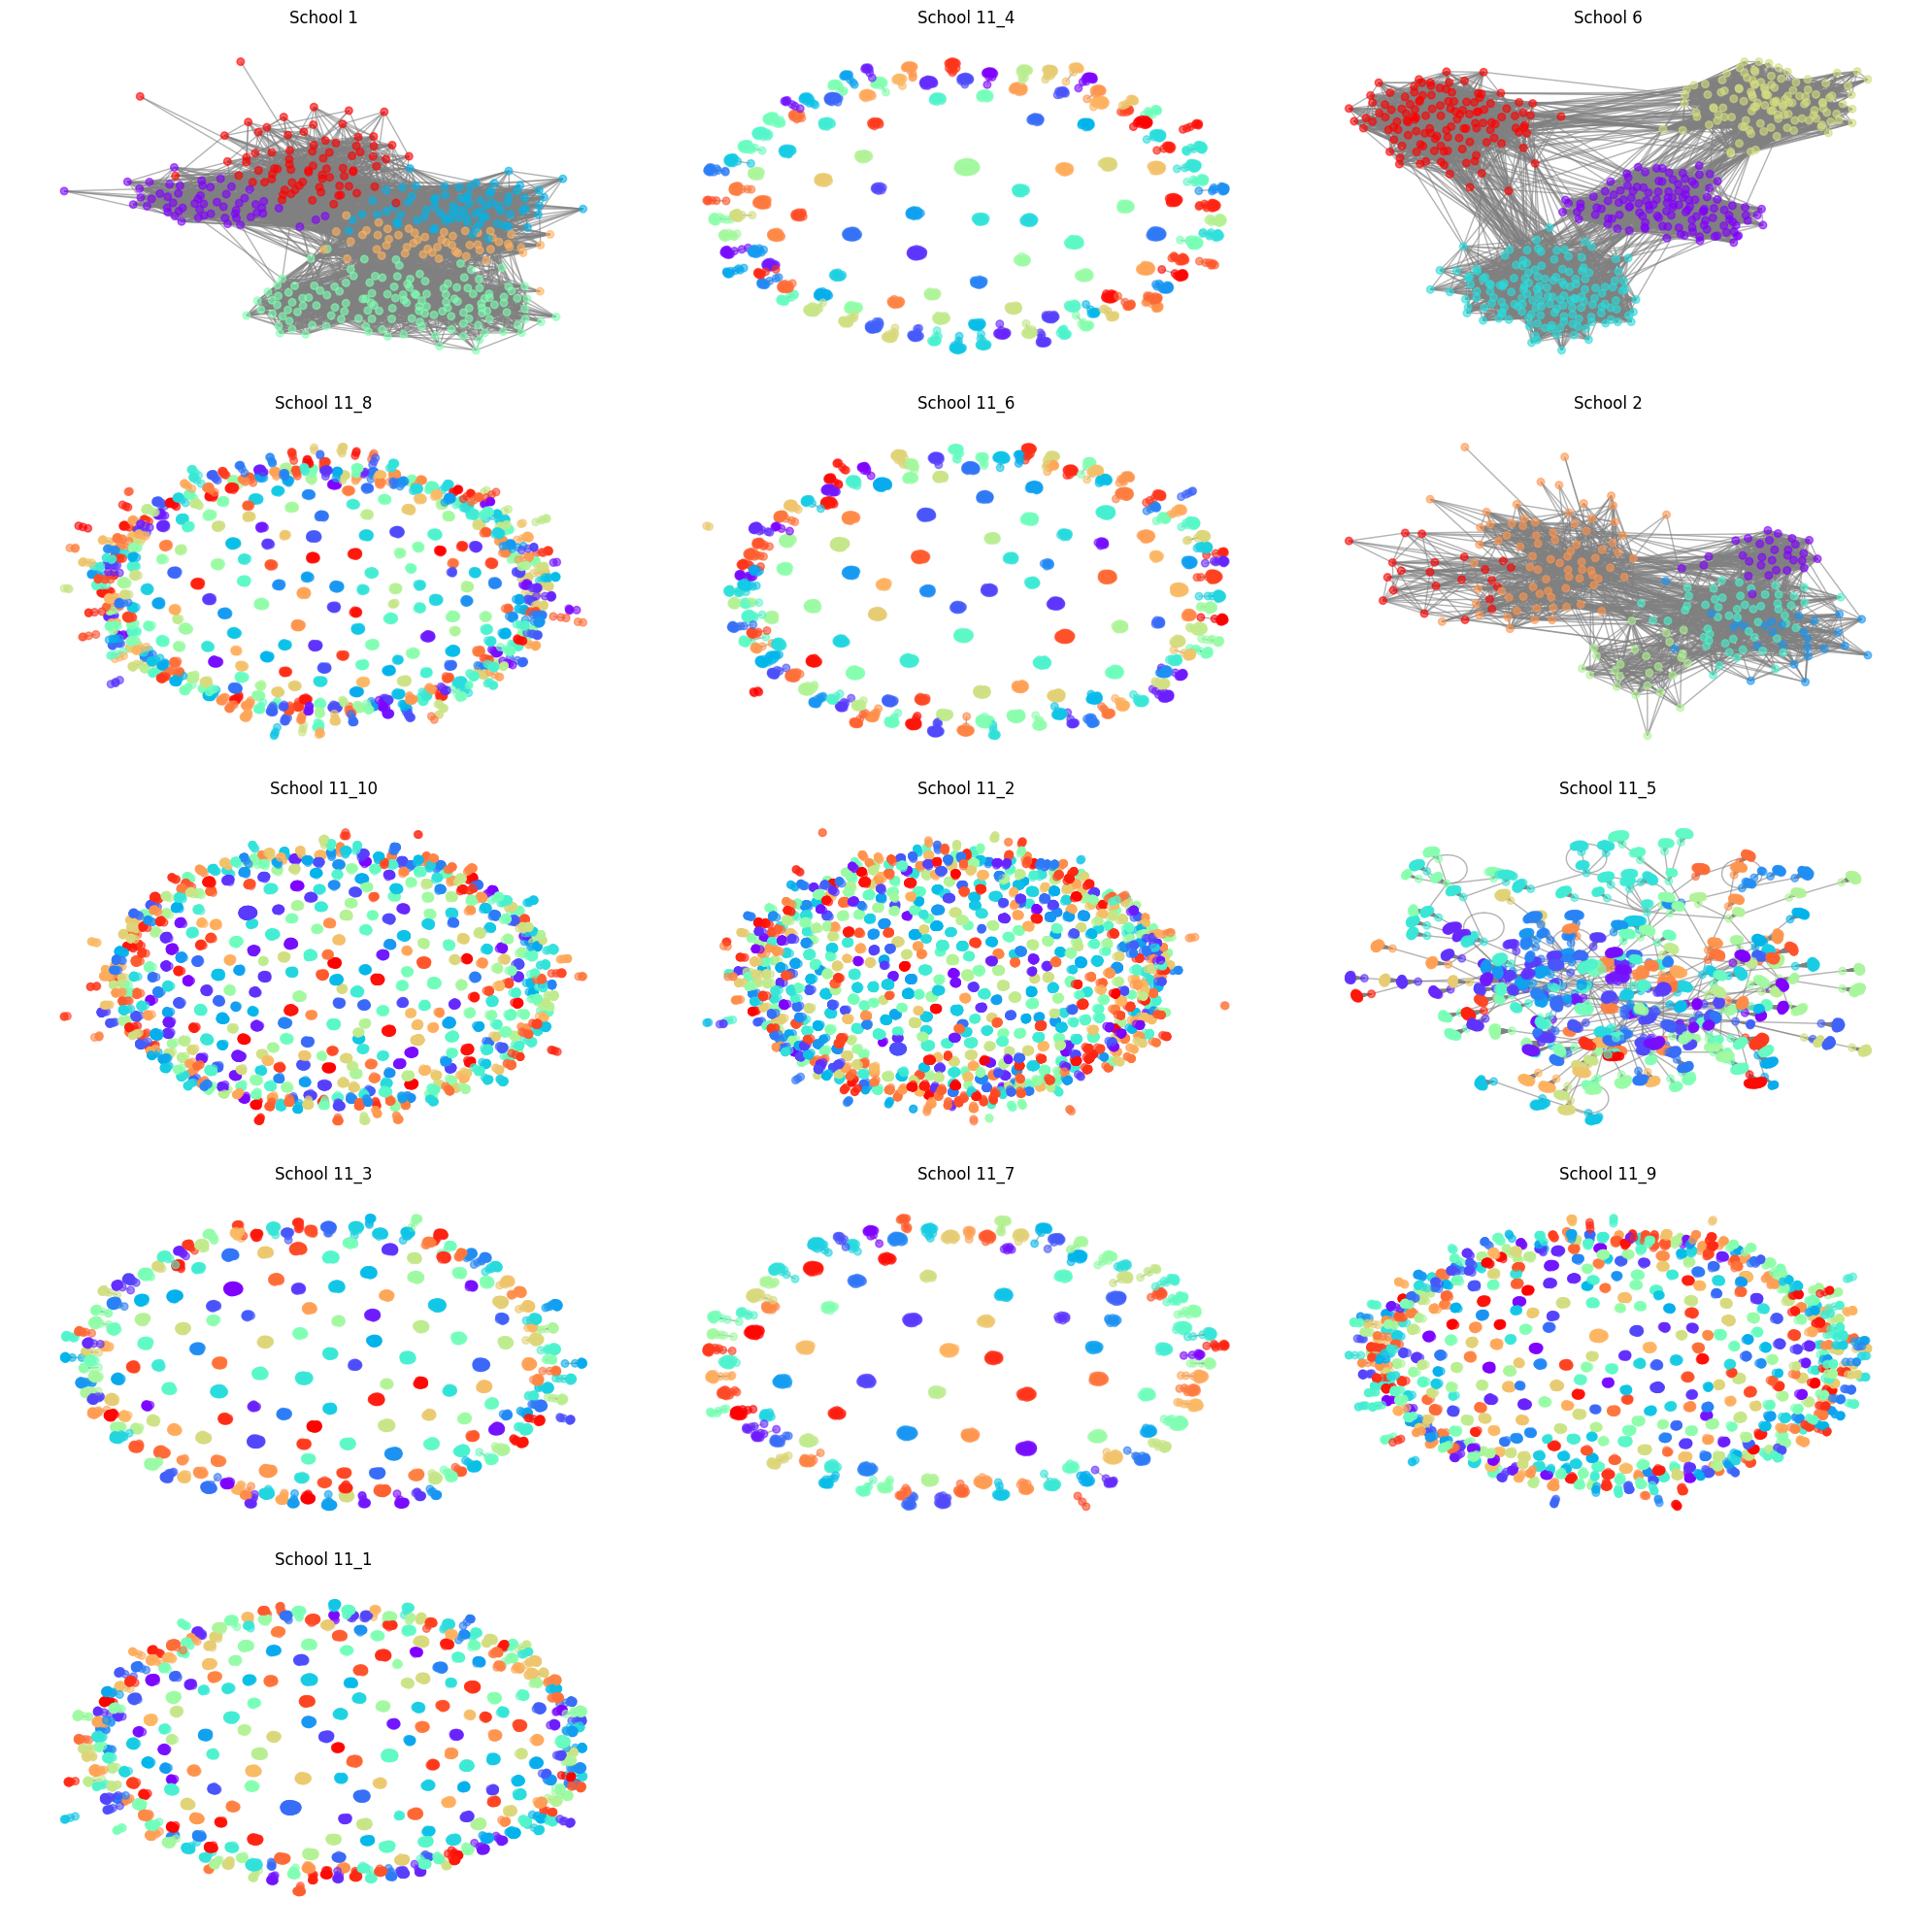

In [14]:
print("Detecting communities using the Louvain method...")
import community as community_louvain
metrics_folder = './metrics'


fig, axes = plt.subplots(5, 3, figsize=(20, 20))
axes = axes.flatten()
for idx, (s, g) in enumerate(graphs.items()):
    if idx >= len(axes):
        break

    G_undirected = g.copy().to_undirected()

    partition = community_louvain.best_partition(G_undirected)
    community_df = pd.DataFrame(list(partition.items()), columns=["Name", "Community"])

    num_communities = len(set(partition.values()))
    print(f'School {s.split("/")[-1].split(".")[0]}, Number of detected communities: {num_communities}')

    unique_communities = list(set(partition.values()))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_communities)))
    color_map = {comm: colors[i] for i, comm in enumerate(unique_communities)}

    pos = nx.spring_layout(G_undirected, seed=42)
    nx.draw(
        G_undirected,
        pos,
        node_color=[color_map[partition[n]] for n in G_undirected.nodes()],
        with_labels=False,
        node_size=30,
        edge_color="gray",
        alpha=0.6,
        ax=axes[idx],
    )
    axes[idx].set_title(f"School {s.split('/')[-1].split('.')[0]}")
for ax in axes[len(graphs):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

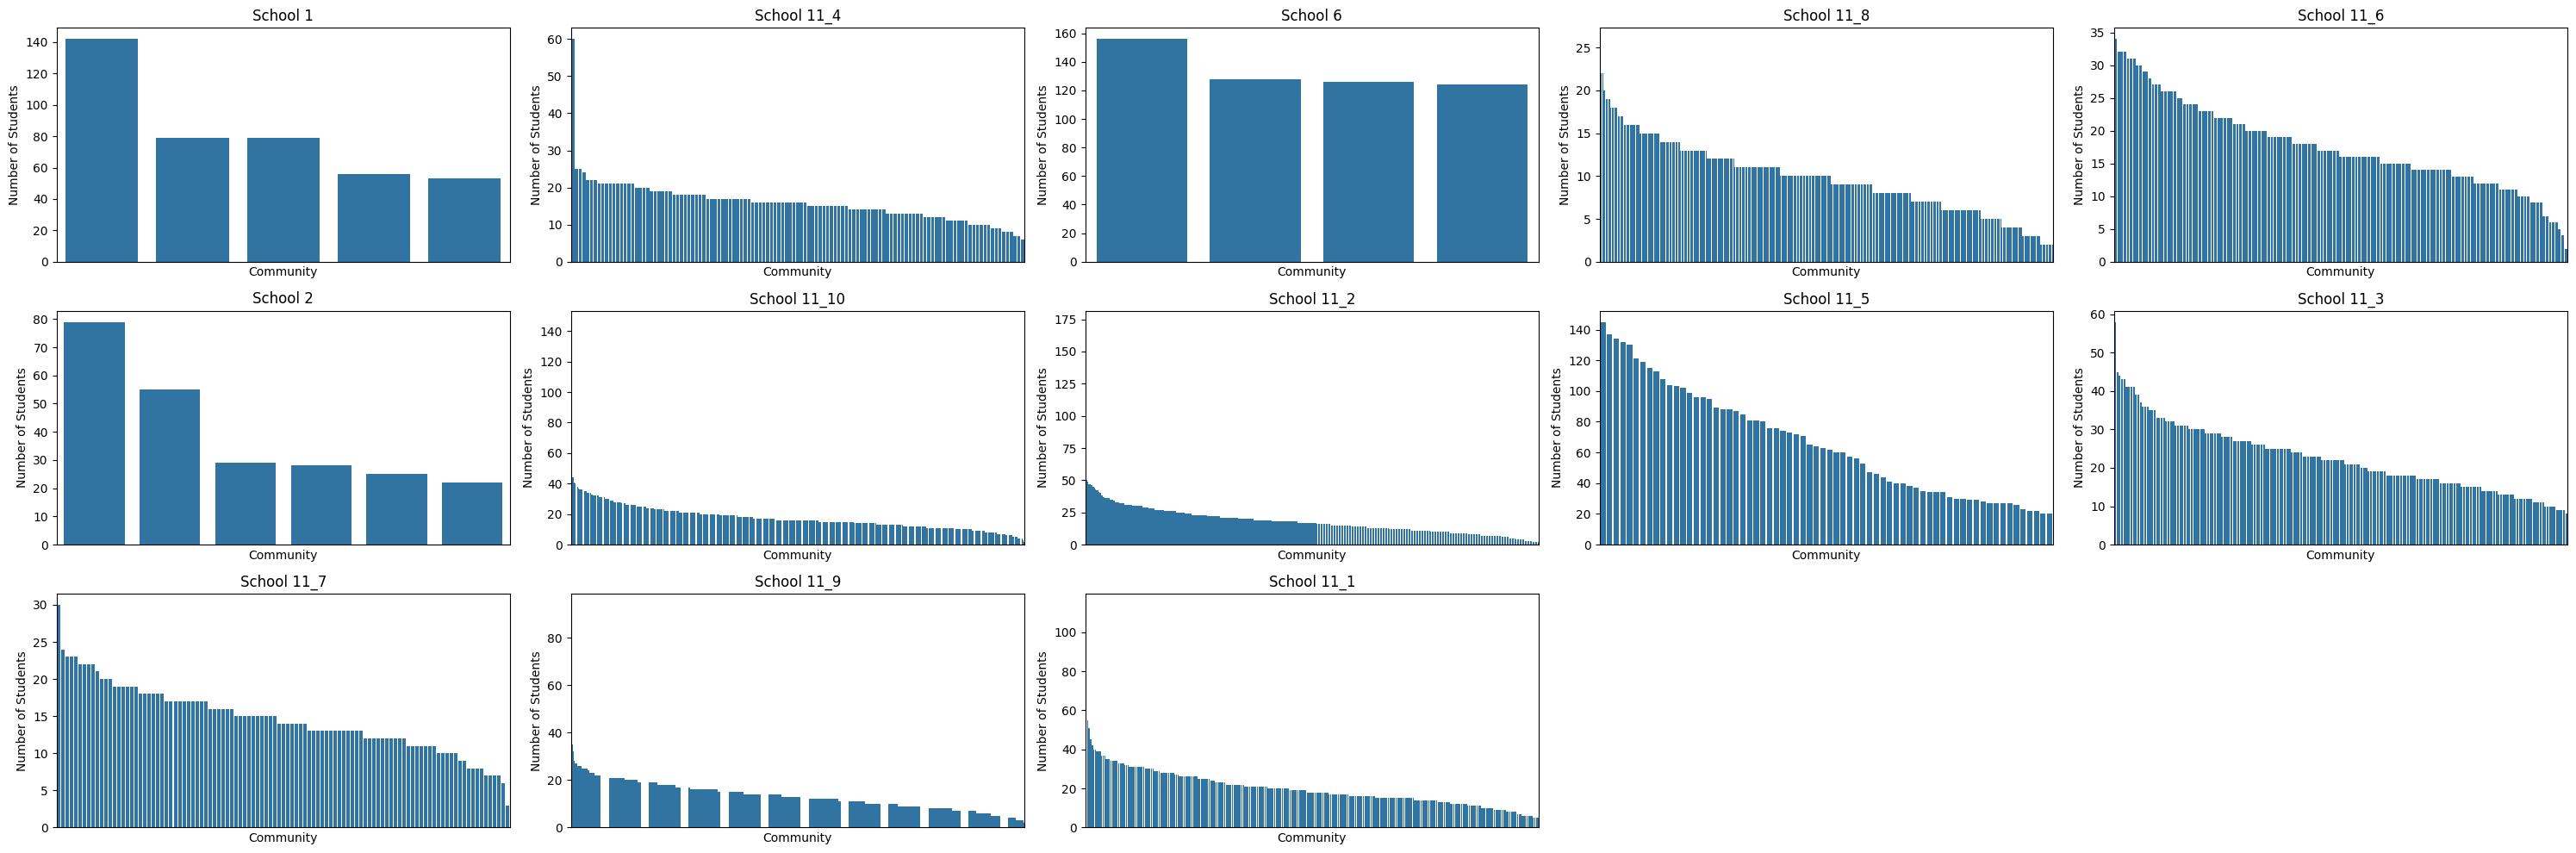

In [15]:
# Create a 5x3 subplot
fig, axes = plt.subplots(3, 5, figsize=(30, 10))
axes = axes.flatten()

for idx, (s, g) in enumerate(graphs.items()):
    if idx >= len(axes):
        break

    G_undirected = g.copy().to_undirected()
    partition = community_louvain.best_partition(G_undirected)
    
    community_df = pd.DataFrame(list(partition.items()), columns=["Name", "Community"])
    community_df.to_csv(f"./student_communities.csv", index=False)
    
    # Sort community sizes before plotting
    community_sizes = community_df["Community"].value_counts().sort_values(ascending=False)

    sns.barplot(
        x=community_sizes.index.astype(str), 
        y=community_sizes.values,
        ax=axes[idx]
    )
    
    axes[idx].set_ylabel("Number of Students")
    axes[idx].set_title(f"School {s.split('/')[-1].split('.')[0]}")
    
    # Fully remove x-axis ticks and labels
    axes[idx].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Hide unused subplots
for ax in axes[len(graphs):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


Computing Network Diameter and Radius...


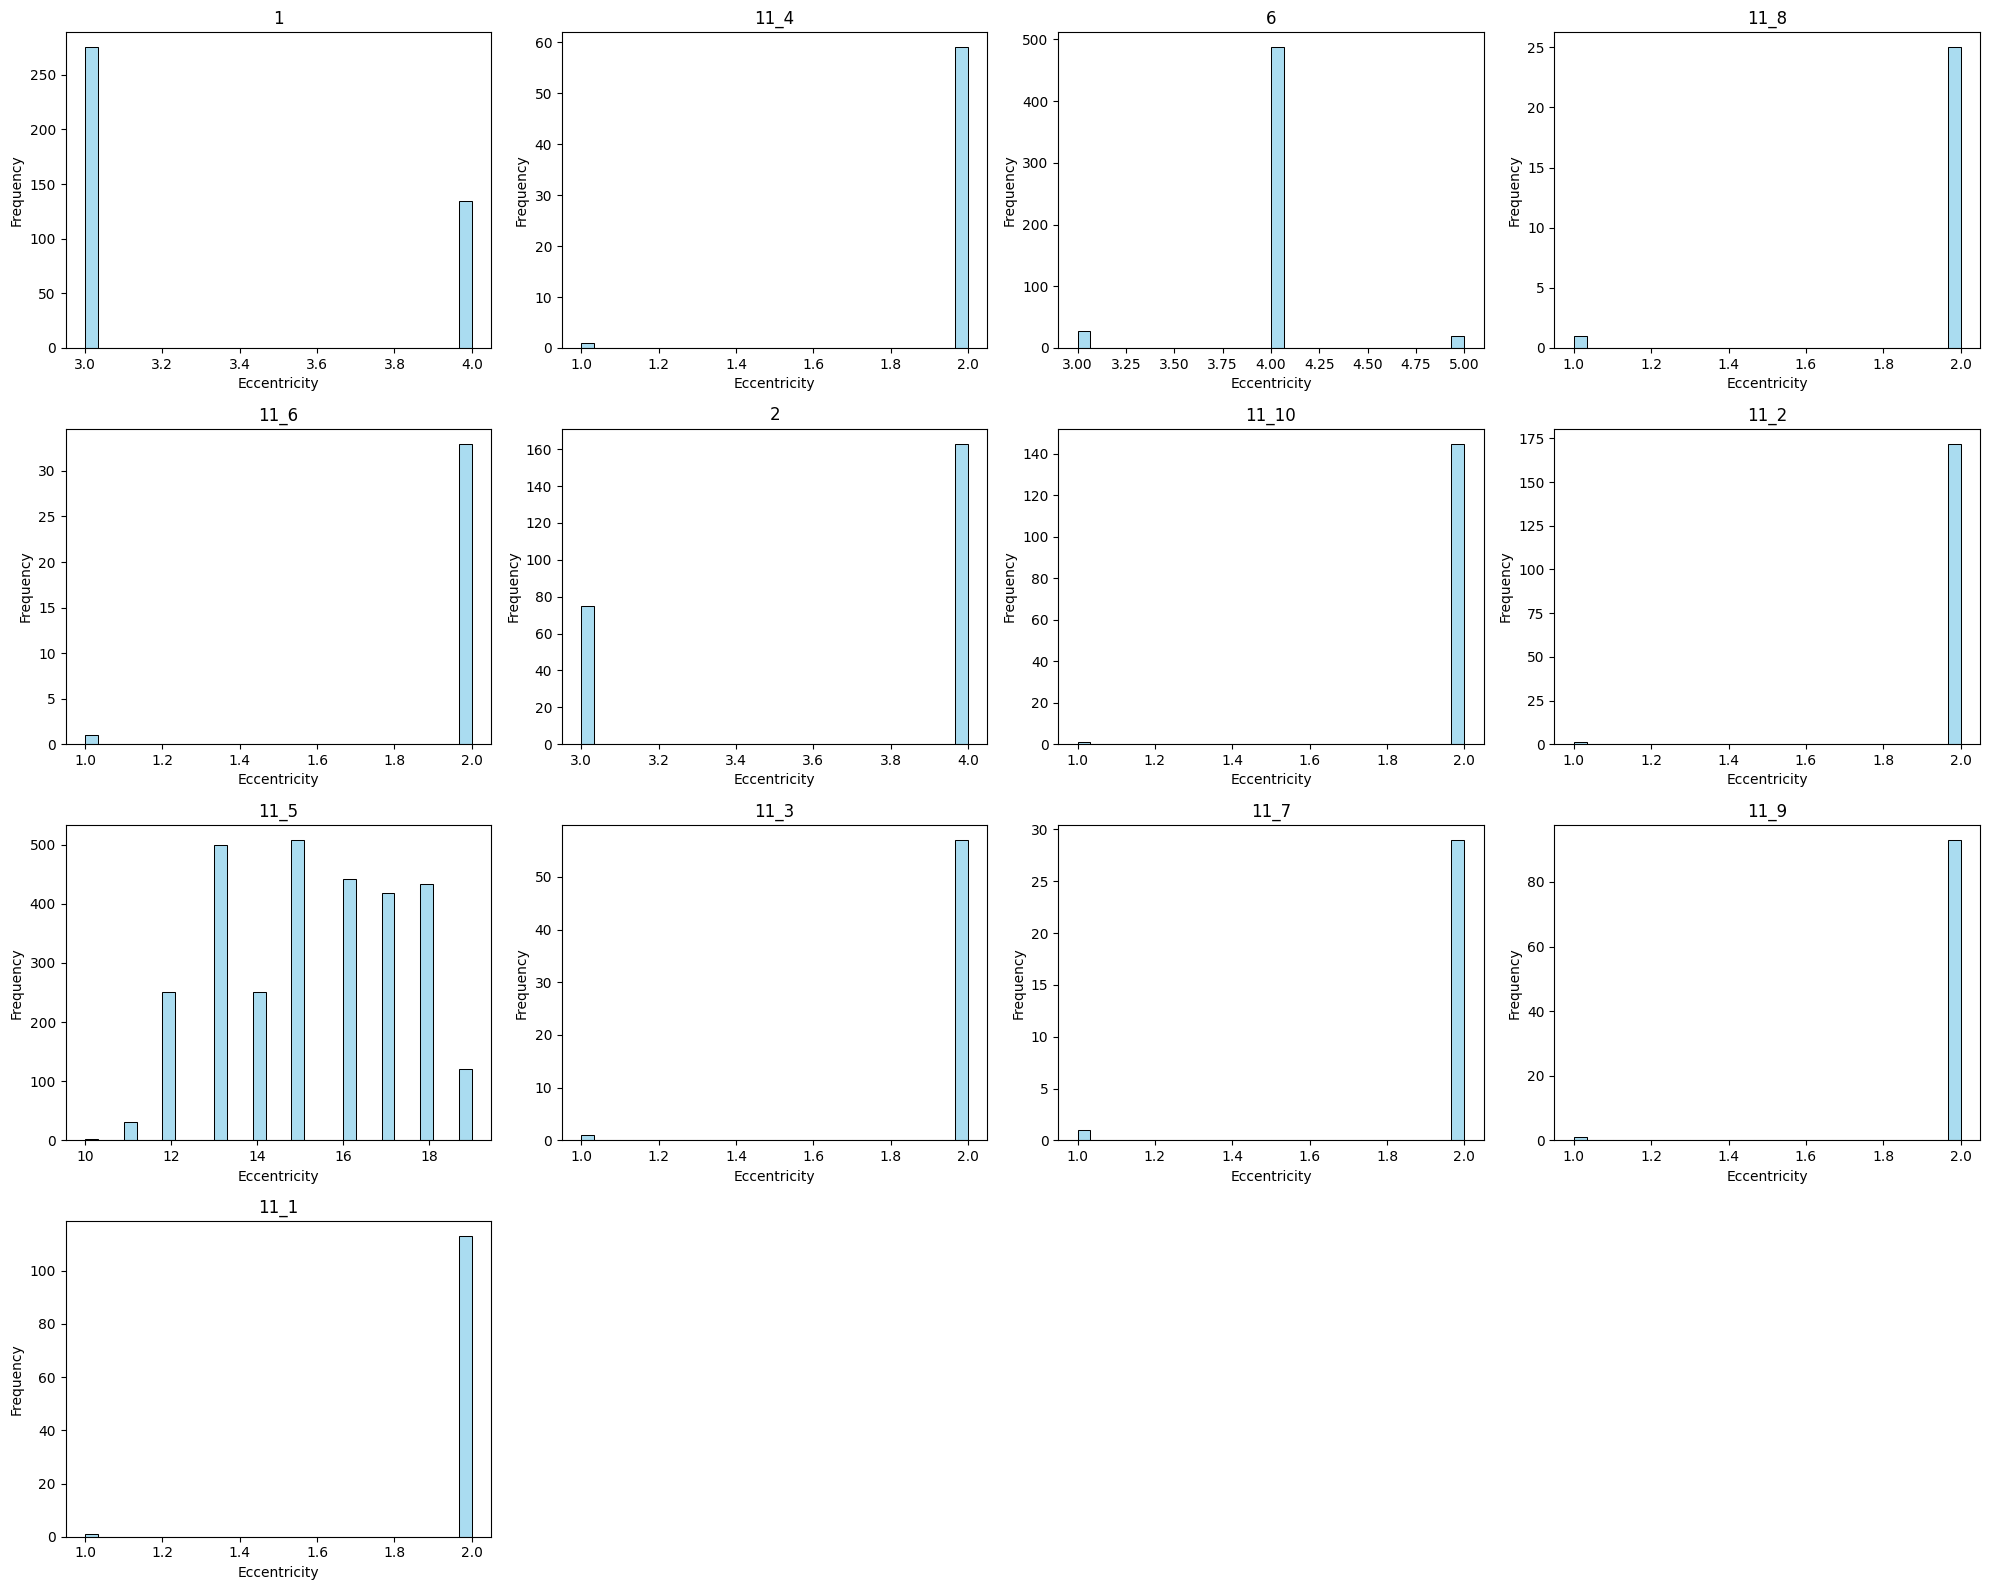

In [ ]:
print("Computing Network Diameter and Radius...")
diameter_results = {}
eccentricity_dict = {}

for s, g in graphs.items():
    # Convert to undirected for diameter computation
    G_undirected = g.copy().to_undirected()

    # Check if graph is connected
    if nx.is_connected(G_undirected):
        network_diameter = nx.diameter(G_undirected)
        network_radius = nx.radius(G_undirected)
        eccentricity_values = nx.eccentricity(G_undirected)
    else:
        # Use the largest connected component for calculations
        largest_cc = max(nx.connected_components(G_undirected), key=len)
        subG = G_undirected.subgraph(largest_cc)
        network_diameter = nx.diameter(subG)
        network_radius = nx.radius(subG)
        eccentricity_values = nx.eccentricity(subG)

    # Save results
    diameter_metrics = {
        "Network Diameter": network_diameter,
        "Network Radius": network_radius,
        "Eccentricity Values": list(eccentricity_values.values())
    }
    diameter_results[s] = diameter_metrics
    eccentricity_dict[s] = list(eccentricity_values.values())

num_schools = len(diameter_results)
cols = 4
rows = int(np.ceil(num_schools / cols))
fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axs = axs.flatten()

for i, (school, metrics) in enumerate(diameter_results.items()):
    ecc = eccentricity_dict[school]
    sns.histplot(ecc, bins=30,  ax=axs[i], color='skyblue', alpha=0.7)
    axs[i].set_title(f"{school.split('/')[-1].split('.')[0]}")
    axs[i].set_xlabel("Eccentricity")
    axs[i].set_ylabel("Frequency")

# Hide unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [197]:
df_diameter = pd.DataFrame([
    {
        "School": k.split('/')[-1].split('.')[0],
        "Network Diameter": v["Network Diameter"],
        "Network Radius": v["Network Radius"]
    }
    for k, v in diameter_results.items()
]).set_index("School")
display(df_diameter)

,Network Diameter,Network Radius
School,,
1,4,3
11_4,2,1
6,5,3
11_8,2,1
11_6,2,1
2,4,3
11_10,2,1
11_2,2,1
11_5,19,10


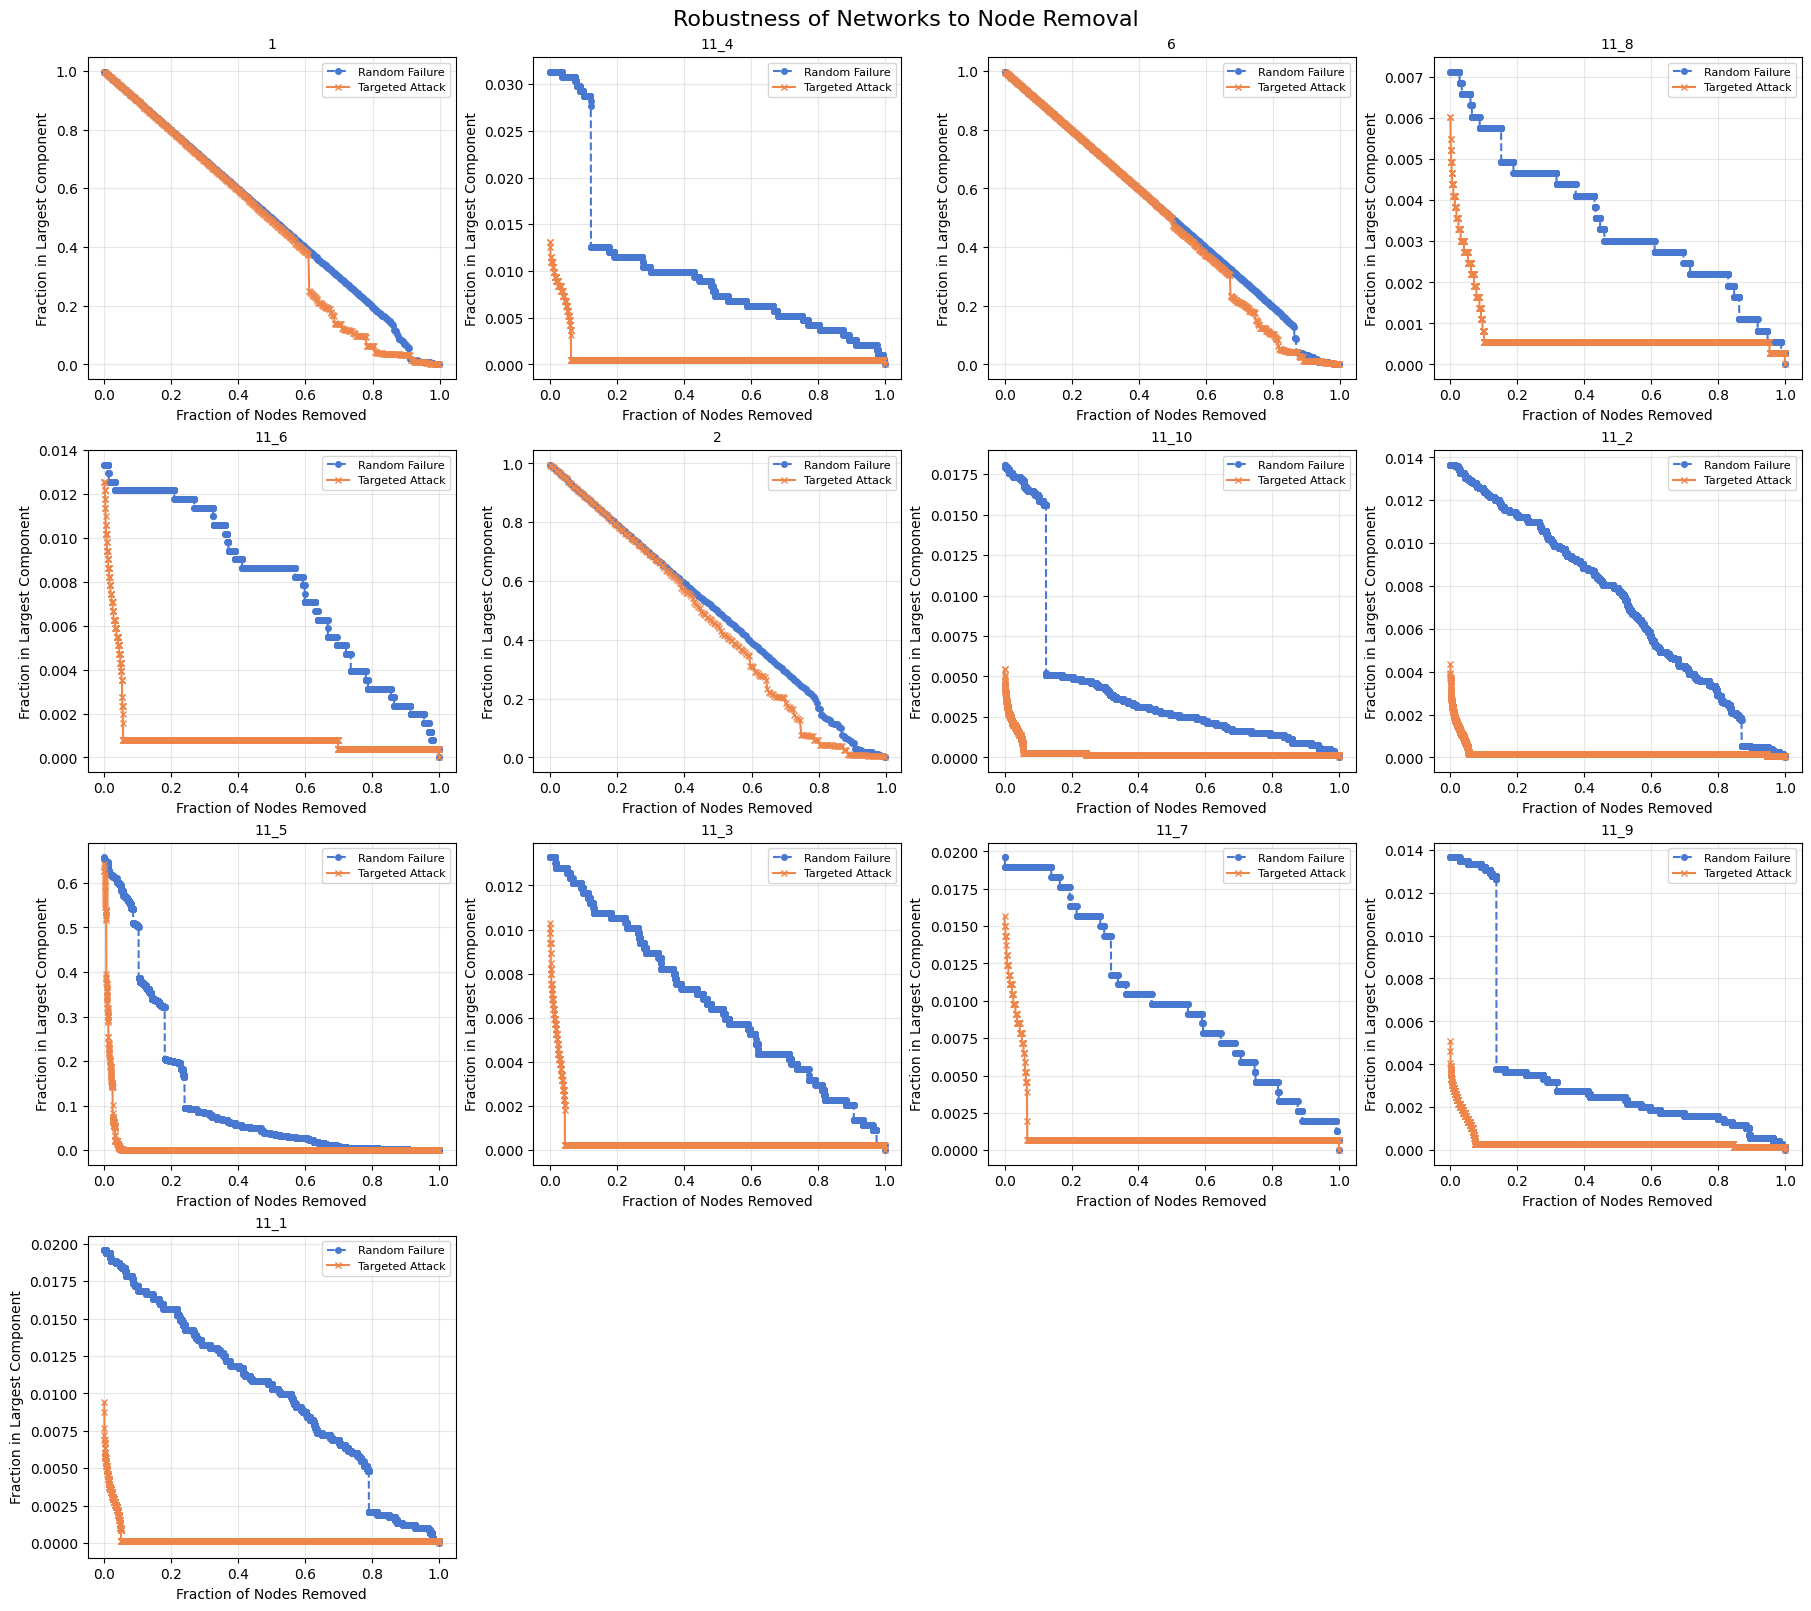

In [200]:
import random
import math
plt.style.use("seaborn-v0_8-muted")
sns.set_palette("muted")
def robustness_analysis(G):
    """
    Simulates random failure and targeted attack on the network.
    Returns the normalized LCC sizes for both strategies.
    """
    G_undirected = G.to_undirected() if nx.is_directed(G) else G.copy()

    nodes = list(G_undirected.nodes())
    hubs = sorted(nodes, key=lambda x: G_undirected.degree(x), reverse=True)
    random_nodes = nodes.copy()
    random.shuffle(random_nodes)

    rf_lcc_sizes, ta_lcc_sizes = [], []

    G_rf = G_undirected.copy()
    G_ta = G_undirected.copy()

    for i in range(len(nodes)):
        G_rf.remove_node(random_nodes[i])
        G_ta.remove_node(hubs[i])

        rf_lcc = max(nx.connected_components(G_rf), key=len, default=[])
        ta_lcc = max(nx.connected_components(G_ta), key=len, default=[])

        rf_lcc_sizes.append(len(rf_lcc) / len(nodes))
        ta_lcc_sizes.append(len(ta_lcc) / len(nodes))

    return rf_lcc_sizes, ta_lcc_sizes

# Determine grid layout
num_graphs = len(graphs)
cols = 4
rows = math.ceil(num_graphs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4 * rows), constrained_layout=True)
axes = axes.flatten()

for i, graph_key in enumerate(graphs):
    graph = graphs[graph_key]
    name = graph_key.split('/')[-1].split('.')[0]

    rf_lcc, ta_lcc = robustness_analysis(graph.copy())

    x_vals = [i / len(rf_lcc) for i in range(len(rf_lcc))]

    ax = axes[i]
    ax.plot(x_vals, rf_lcc, label="Random Failure", linestyle='--', marker='o', markersize=4)
    ax.plot(x_vals, ta_lcc, label="Targeted Attack", linestyle='-', marker='x', markersize=4)

    ax.set_title(name, fontsize=10)
    ax.set_xlabel("Fraction of Nodes Removed")
    ax.set_ylabel("Fraction in Largest Component")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Robustness of Networks to Node Removal", fontsize=16)
plt.show()

## Triad census


003: Number 8916615, 78.7723%
012: Number 1481331, 13.0866%
102: Number 707012, 6.2460%
021D: Number 63914, 0.5646%
021U: Number 16593, 0.1466%
021C: Number 24098, 0.2129%
111D: Number 19870, 0.1755%
111U: Number 46478, 0.4106%
030T: Number 8454, 0.0747%
030C: Number 200, 0.0018%
201: Number 11805, 0.1043%
120D: Number 4447, 0.0393%
120U: Number 6525, 0.0576%
120C: Number 2186, 0.0193%
210: Number 6460, 0.0571%
300: Number 3496, 0.0309%
003: Number 1163378379, 99.7074%
012: Number 3399554, 0.2914%
102: Number 0, 0.0000%
021D: Number 14331, 0.0012%
021U: Number 0, 0.0000%
021C: Number 0, 0.0000%
111D: Number 0, 0.0000%
111U: Number 0, 0.0000%
030T: Number 0, 0.0000%
030C: Number 0, 0.0000%
201: Number 0, 0.0000%
120D: Number 0, 0.0000%
120U: Number 0, 0.0000%
120C: Number 0, 0.0000%
210: Number 0, 0.0000%
300: Number 0, 0.0000%
003: Number 20502104, 81.2399%
012: Number 2901133, 11.4958%
102: Number 1557450, 6.1714%
021D: Number 59243, 0.2348%
021U: Number 21361, 0.0846%
021C: Number 33

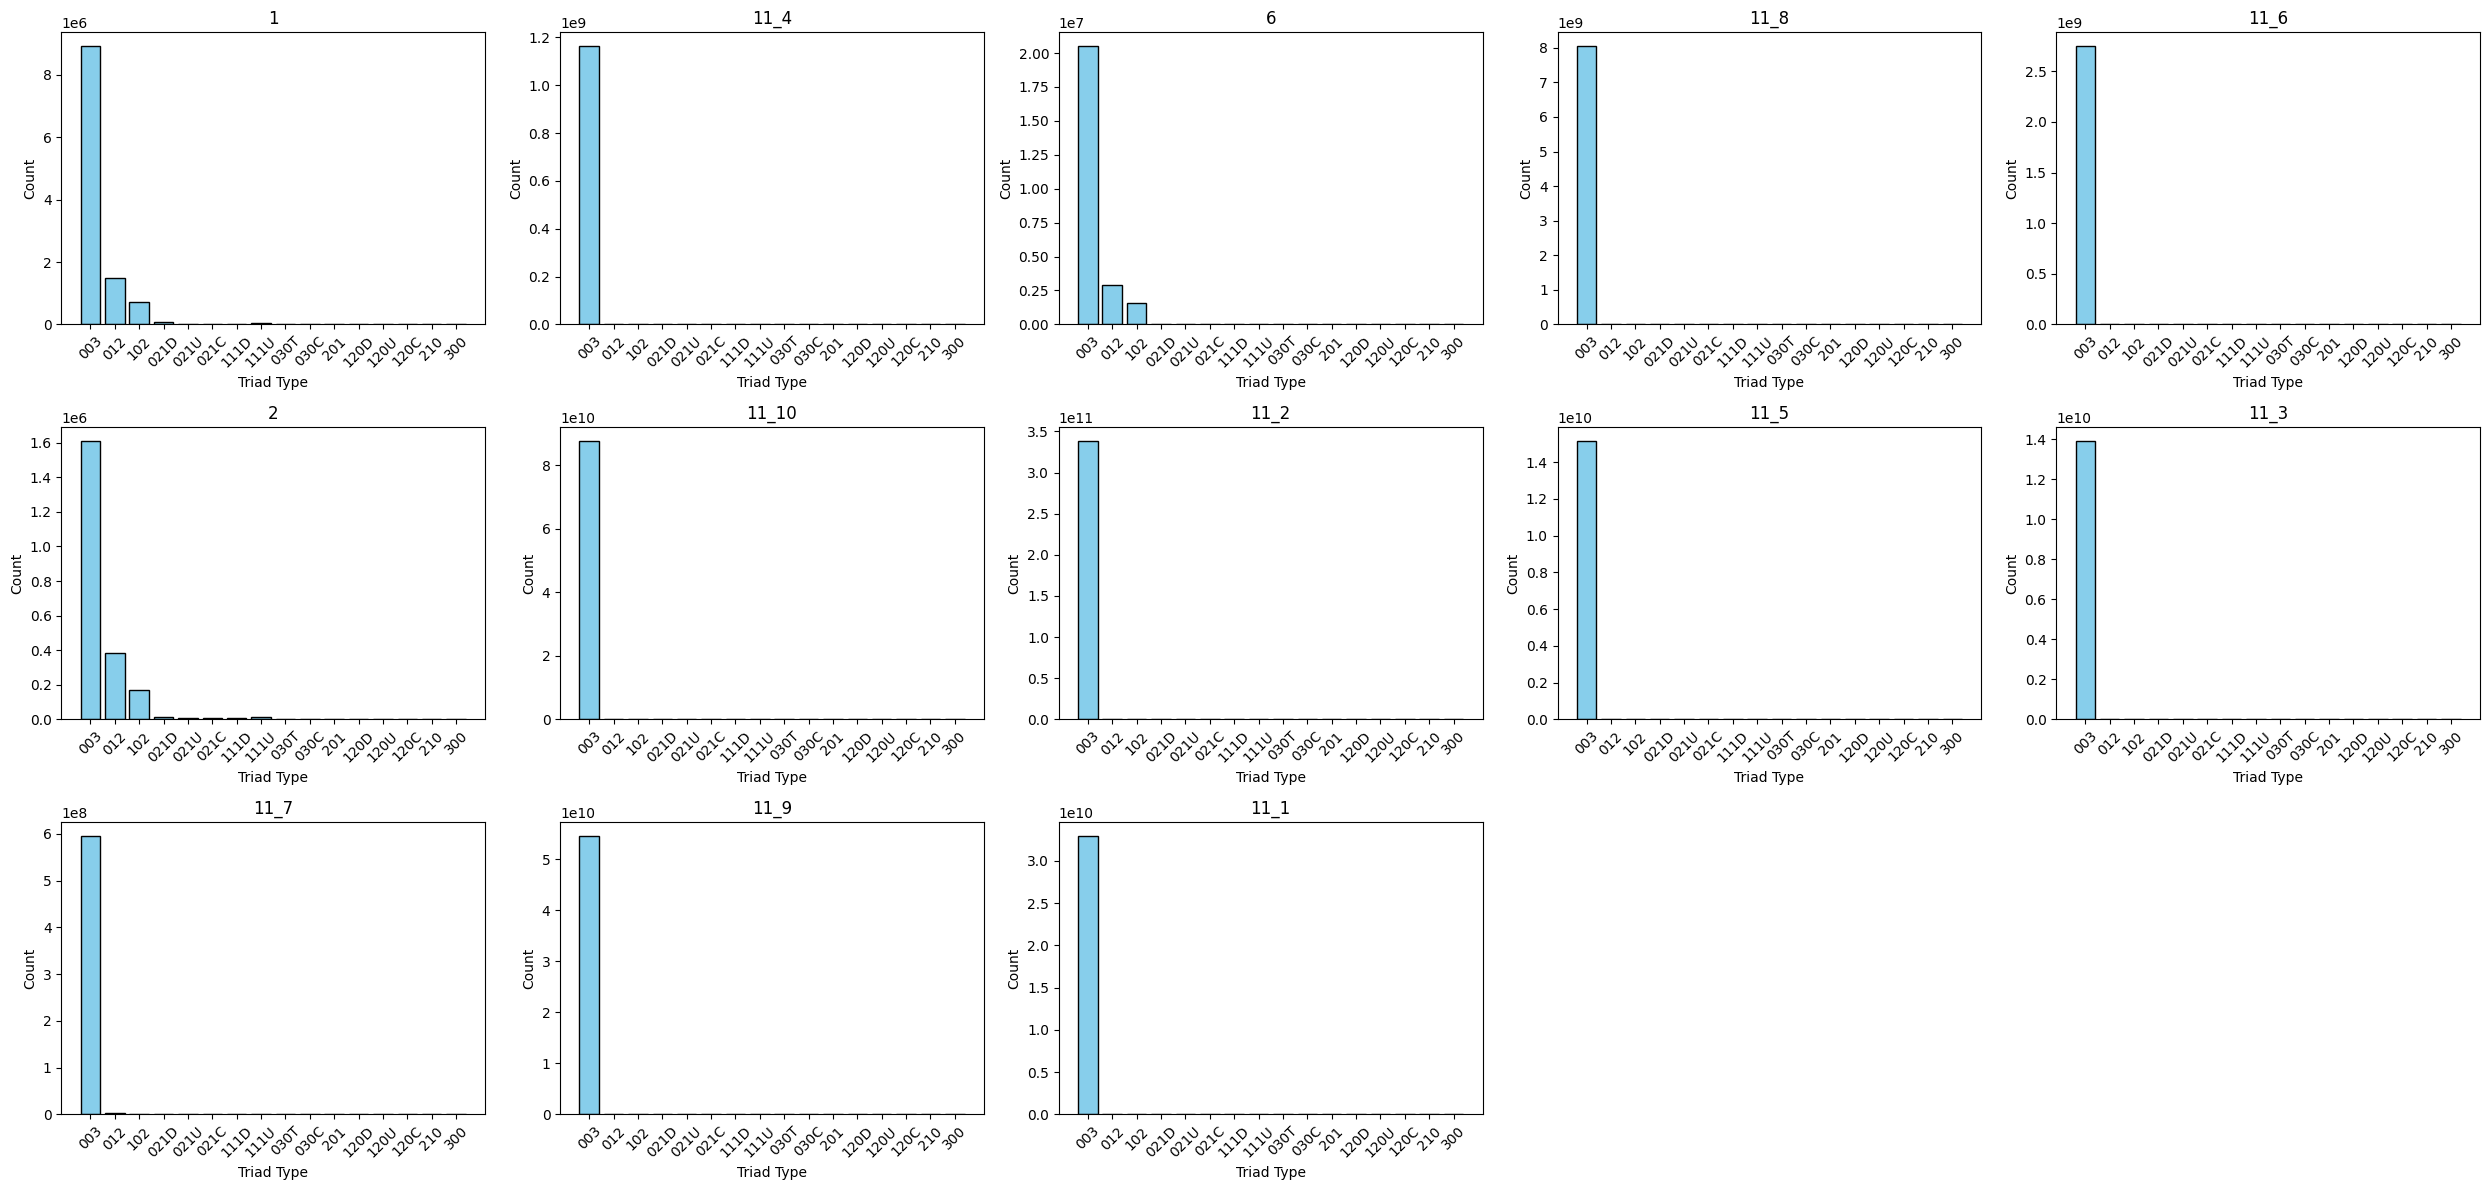

In [190]:
def plot_triad_census(triad_counts, ax=None, title=None):
    total_triads = sum(triad_counts.values())
    if total_triads == 0:
        return {key: 0 for key in triad_counts}  # Avoid division by zero

    # Print triad counts and percentages
    for key, value in triad_counts.items():
        percentage = (value / total_triads) * 100
        print(f"{key}: Number {value}, {percentage:.4f}%")

    # Plot the number of each triad type as a bar plot
    triad_labels = list(triad_counts.keys())
    triad_values = list(triad_counts.values())

    if ax is None:
        plt.figure(figsize=(10, 6))
        plt.bar(triad_labels, triad_values, color='skyblue', edgecolor='black')
        plt.title(title if title else 'Triad Census Distribution')
        plt.xlabel('Triad Type')
        plt.ylabel('Number of Occurrences')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        ax.bar(triad_labels, triad_values, color='skyblue', edgecolor='black')
        ax.set_title(title if title else 'Triad Census')
        ax.set_xlabel('Triad Type')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)

# Prepare subplots
num_graphs = len(graphs)
cols = 5
rows = int(np.ceil(num_graphs / cols))
fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axs = axs.flatten()

for i, (school, g) in enumerate(graphs.items()):
    G_directed = g.copy().to_directed()
    triads = nx.triadic_census(G_directed)
    title = school.split('/')[-1].split('.')[0]
    plot_triad_census(triads, ax=axs[i], title=title)

# Hide unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()